# Introduction to Data Preprocessing and Exploration

We start by importing essential Python libraries for data handling and visualization. This includes Pandas for data manipulation, Seaborn and Matplotlib for plotting, and Scikit-learn for machine learning tasks.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from summarytools import dfSummary


Our first step is to load our dataset, 'medical_clean.csv', into a Pandas DataFrame. We then use dfSummary from the 'summarytools' package to get a quick overview of our data, helping us understand its structure, missing values, and variable types.

In [2]:
# Load the data
medical_data = pd.read_csv('medical_clean.csv')
# Generate a summary of the data
dfSummary(medical_data)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,CaseOrder[int64],Mean (sd) : 5000.5 (2886.9)min < med < max:1.0 < 5000.5 < 10000.0IQR (CV) : 4999.5 (1.7),"10,000 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8pXeV/AAAACXBIWXMAAA9hAAAPYQGoP6dpAAABxklEQVR4nO3XQU7CYBBA4fkbJSCkDSHCAbwBSw7hYT0EJ2DhxhU7EtKUUDEarCcAKTXqS963baczixcSUtM0If132V8fIF3i5rsXUkqDiOhd+f0sIj6vnO06T91Nvbvr/HvTNIdTD8+GmlIaTCaTxzzPx223Ho/H27quH0aj0UuWZR+/OU/dTb37J+Z3u12ZUno6Fet3v6i9PM/Hi8XiUBTFW5vF6/V6vFqt7ufz+fNsNivbzHadp+6m3t11vqqq/nK5HG+3215EXBVqREQURfE2nU5f2ywvy3IQETEcDlvPdp2n7qbe/RPzETE499A/U0IwVCEYqhAMVQiGKgRDFYKhCsFQhWCoQjBUIRiqEAxVCIYqBEMVgqEKwVCFYKhCMFQhGKoQDFUIhioEQxWCoQrBUIVgqEIwVCEYqhAMVQiGKgRDFYKhCsFQhWCoQjBUIRiqEAxVCIYqBEMVgqEKwVCFYKhCMFQhGKoQDFUIhioEQxWCoQrBUIVgqEIwVCEYqhAMVQiGKgRDFYKhCsFQhWCoQjBUIRiqEAxVCIYqBEMVgqEK4eaSl6qq6rf98H6/70dE1HXd32w2d785T91Nvbvr/CV9fQGSljnmc7n3zQAAAABJRU5ErkJggg=="">",0(0.0%)
2,Customer_id[object],1. C4124032. D2943643. B2032104. C201775. K2160206. O8966257. M3047798. H894379. A14383410. L21446011. other,"1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)9,990 (99.9%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8pXeV/AAAACXBIWXMAAA9hAAAPYQGoP6dpAAADLklEQVR4nO3cwY3TYBRG0ecogmFja2QpJUAPKYItvdOFNzCswoIeriVzTgX/4kpPkfxleb1eA4Xb2Q/g/yE2MmIjIzYyYiMjNjJiIyM2MmIjIzYyt2VZvi3L8nb2Q7i+28x8nZnPZz+E63NGyYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3MbWZ+zsyfsx/C9S3+xYiKM0pGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kDF4IeOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEZGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKBmxkREbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYy1lVkrKvIOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKJllZr7MzKezH8L13fd9/76u6/vZD+H67uu6vj+fz9/btn2c/Riu6ziOt/vMzLZtH4/H49fZD+La/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjc5/59/nH2Q/h2o7jeFv2ff/h40kKPgsnY11Fxg8EMmIjIzYyYiMjNjJiIyM2MmIjIzYyfwFj50uCzHpkKgAAAABJRU5ErkJggg=="">",0(0.0%)
3,Interaction[object],1. 8cd49b13-f45a-4b47-a2bd-173ffa2. dc1799a6-61d1-44a3-9b94-b895843. dc6bab10-659b-4c78-ba87-87ffa34. 1cb70cc8-47b7-4192-8bed-faad0f5. 06d0da86-5600-472d-a35d-7632776. 18b8277b-c5aa-4f80-8439-b12ad87. 32cb2440-1fda-4ed6-b00b-2829bf8. 344ea878-976d-469b-8332-e1b1ab9. 52e1962b-8ed4-447a-a818-df09c210. 8ce5b34d-efff-4229-b23e-5510e211. other,"1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)9,990 (99.9%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8pXeV/AAAACXBIWXMAAA9hAAAPYQGoP6dpAAADLklEQVR4nO3cwY3TYBRG0ecogmFja2QpJUAPKYItvdOFNzCswoIeriVzTgX/4kpPkfxleb1eA4Xb2Q/g/yE2MmIjIzYyYiMjNjJiIyM2MmIjIzYyt2VZvi3L8nb2Q7i+28x8nZnPZz+E63NGyYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3MbWZ+zsyfsx/C9S3+xYiKM0pGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kDF4IeOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEZGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI


# Feature Selection and Data Cleaning

We proceed by cleaning our data. This involves dropping columns that might not be relevant to our prediction task. In our case, we remove certain survey columns like 'Item1' to 'Item8', as well as demographic information like 'City', 'State', and 'Job'.
The 'Age' column is converted to a floating-point type to ensure numerical consistency, as machine learning models work better with numerical data.


In [3]:
# Dropping survey columns Item1 to Item8
medical_data.drop(['Item1', 'Item2', 'Item3', 'Item4', 'Item5',
                  'Item6', 'Item7', 'Item8'], axis=1, inplace=True)
# Dropping demographic columns
medical_data.drop(columns=['CaseOrder', 'Customer_id', 'Interaction', 'UID', 'City', 'State', 'County', 'Zip',
                  'Lat', 'Lng', 'Area', 'TimeZone', 'Job', 'Marital', 'Children', 'Gender', 'Population'], inplace=True)
# Converting "Age" column to float
medical_data['Age'] = medical_data['Age'].astype('float64')


# Identifying Variable Types

To prepare for modeling, we identify categorical and numerical columns in our dataset. This is crucial as different types of data require different preprocessing techniques.


In [4]:
# Identifying Categorical Columns
print(medical_data.select_dtypes(include='object').columns +' (Categorical)')
# Identifying Numerical Columns
print(medical_data.select_dtypes(exclude='object').columns +' (Numerical)')

Index(['ReAdmis (Categorical)', 'Soft_drink (Categorical)',
       'Initial_admin (Categorical)', 'HighBlood (Categorical)',
       'Stroke (Categorical)', 'Complication_risk (Categorical)',
       'Overweight (Categorical)', 'Arthritis (Categorical)',
       'Diabetes (Categorical)', 'Hyperlipidemia (Categorical)',
       'BackPain (Categorical)', 'Anxiety (Categorical)',
       'Allergic_rhinitis (Categorical)', 'Reflux_esophagitis (Categorical)',
       'Asthma (Categorical)', 'Services (Categorical)'],
      dtype='object')
Index(['Age (Numerical)', 'Income (Numerical)', 'VitD_levels (Numerical)',
       'Doc_visits (Numerical)', 'Full_meals_eaten (Numerical)',
       'vitD_supp (Numerical)', 'Initial_days (Numerical)',
       'TotalCharge (Numerical)', 'Additional_charges (Numerical)'],
      dtype='object')



# Visualizing Data Relationships

Next, we create a heatmap of the correlation matrix using Seaborn. This visualization helps us understand the relationships between different numerical variables, and is key in identifying collinear features that we might need to address.


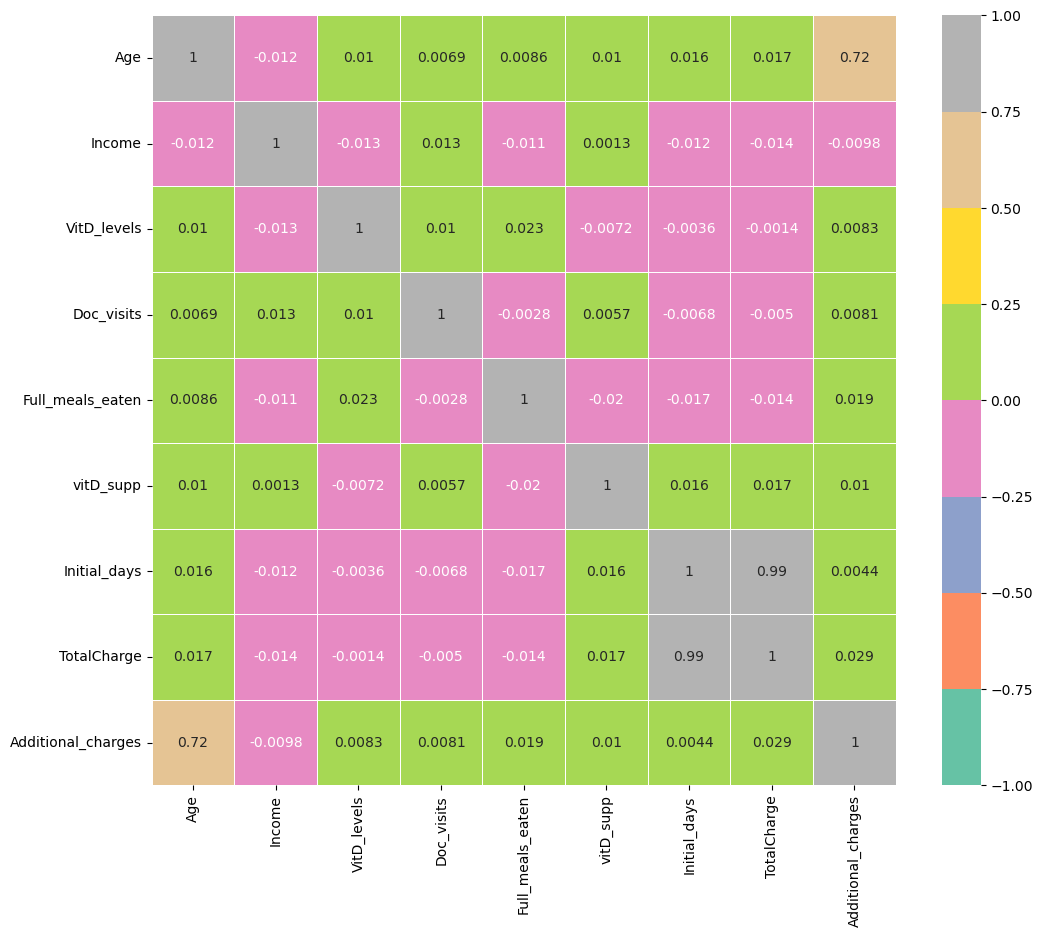

In [5]:
# Compute correlation matrix
corr_matrix = medical_data.corr(numeric_only=True)

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True,vmin=-1, vmax=1,linewidths=.5, cmap="Set2")
plt.show()

In [6]:
# Dropping highly correlated features
medical_data.drop(columns=['Additional_charges','Initial_days'],inplace=True)


# Feature Encoding and Scaling

We then focus on encoding our categorical variables. For binary categories, we use Label Encoding, converting them into 0s and 1s. For other categorical variables, we apply One-Hot Encoding, which is effective in handling data multiple categories.
For our numerical variables, we use StandardScaler from Scikit-learn to standardize their range. This normalization step is important as it brings all features to the same scale, improving model performance.


In [7]:
def encode_binary(data, binary_columns=None):
    """
    Encodes binary columns into 0s and 1s using LabelEncoder.

    Parameters:
    - data: DataFrame to be encoded
    - binary_columns: List of binary columns to be encoded into 0s and 1s. If None, it will be inferred from the data.

    Returns:
    - DataFrame with binary encoded columns
    """
    
    # If 'binary_columns' is not provided, infer it from the data.
    if binary_columns is None:
        binary_columns = data.nunique()[data.nunique() == 2].keys().tolist()

    le = LabelEncoder()

    for col in binary_columns:
        data[col] = le.fit_transform(data[col])
        data[col] = data[col].astype('int64')

    return data

In [8]:
def encode_one_hot(data, columns_to_encode):
    """
    Encodes specified columns using one-hot encoding.

    Parameters:
    - data: DataFrame to be encoded
    - columns_to_encode: List of columns to be one-hot encoded

    Returns:
    - DataFrame with one-hot encoded columns
    """
    
    # Initialize a OneHotEncoder with specific settings:
    # 'drop="first"' means drop the first category in each feature to avoid multicollinearity.
    # 'sparse_output=False' means the output should be a dense array (not a sparse matrix).
    encoder = OneHotEncoder(drop='first', sparse_output=False)

    # Apply the encoder to transform the specified columns into one-hot encoded format.
    encoded_data = encoder.fit_transform(data[columns_to_encode])

    # Convert the encoded data into a DataFrame with appropriate column names.
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(columns_to_encode))

    # Concatenate the original data (excluding the columns_to_encode) with the encoded data.
    # The final result replaces the original categorical columns with their one-hot encoded counterparts.
    data = pd.concat([data.drop(columns_to_encode, axis=1), encoded_df], axis=1)
    return data


In [9]:
# Copy the original data to avoid modifying it directly
processed_data = medical_data.copy()

In [10]:
columns_to_encode = processed_data.select_dtypes(include=['object']).columns.drop('ReAdmis')

In [11]:
processed_data = encode_binary(processed_data)

In [12]:
processed_data = encode_one_hot(processed_data, columns_to_encode)

In [13]:
# Standard scaling for numerical variables
scaler = StandardScaler()
numerical_columns = processed_data.select_dtypes(include=['float64']).columns

processed_data[numerical_columns] = scaler.fit_transform(processed_data[numerical_columns])

In [14]:
dfSummary(processed_data)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Age[float64],Mean (sd) : 0.0 (1.0)min < med < max:-1.7 < -0.0 < 1.7IQR (CV) : 1.7 (0.0),72 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8pXeV/AAAACXBIWXMAAA9hAAAPYQGoP6dpAAACrUlEQVR4nO3asU/bQBiG8e8Sgi6E2gpJYcvSEalDJBaWbh37x3bt1iFInRm6dGJBSMgkiksUY6dDkaoONPY5Jn2t57eGL3Z0z+ELwm02GwP+d5193wBQxsG+bwDt4Zzrm9lh4Ph6s9k8vvQioWInnHP90Wj0KYqiYcj8YrFInHOfX4p1a6hN7hK0ymEURcPLy8vHOI5XVQbn87mfzWbD+/v7QzOrHmrTuwTtE8fx6vT09GfAaP9fL277jdroLgHKKnVGbWqXYPfaelRr7Zepmgtm9vtPd0Xg7F4WvM1HtUZDzfO8Z2aRcy70LUJj8ScnJx/jOB6EXDTP816apu+Oj49/dDqdrOr8w8PD0jn3xcwqHZee1Ym8tUe1xkJN07SXZdn7yWTS7Xa7lResTixZlnkzO7+4uPg2Ho8XVa99c3MzvL6+fjudTr+fnZ0lVWZvb2/fXF1dfZhMJuOQz10z8qgoil4cx0nbjmqNhbperw+890fT6XRVdbHN6sXyPHvkvc9CFixJkr6Z2WAwqHw2T5KkH/q560aeZZnP8/x8tVp9NbPKn7vmEzAqiqIXMlhG42fUkMU2qx9L1evt2mtHbvZngz49PXWrztZ9AtbdJNu09suUsrqbO8SOnoBBm6QMQsVf9rFJyuC/pyCBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCHhoMwPzedzX/WNl8ulNzNL09Tf3d0dvea86rVV77vufJm+fgFFPnL1B2RO9gAAAABJRU5ErkJggg=="">",0(0.0%)
2,Income[float64],Mean (sd) : 0.0 (1.0)min < med < max:-1.4 < -0.2 < 5.8IQR (CV) : 1.2 (0.0),"9,993 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8pXeV/AAAACXBIWXMAAA9hAAAPYQGoP6dpAAACkElEQVR4nO3cMW/aQBiA4e9KQAYiAyKCjZWhUgdGlv6D/tiu3YrEjsQ/YEMyGIQbB2PcKVPTJNzZ6X3u++xnbnhldHB3pigKAXz36V9PAHiPuyofboxpi0jL4RHnoigey5oP9KosVGNMezgcfgvDcGD7jOPxuDfGfCdWVPlGbYVhOJjP54+9Xi+9dfDhcAiWy+UgiqKWiBDqf67Sr34RkV6vl45Go1+Ww9ulTgZqsZiCCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQpv/jPlsLEkvF6vTYtxwB9eDdVlY0mWZUGe55/TNP0pIrZ/oQIi8vYb1XpjyWazGazX687lcmk4zA8QkXduSrHZWLLf79lQgtKwmIIKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFSo/1+8iz/OmiITGGJvhXAdUI96GmiRJM8uyL5PJpNFoNG6+aYXrgOrF21DP5/NdEASd2WyWjsfj/S1juQ6ofrwN9Vm327W9EojdWzXCYgoqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQre70e15XiMRYSjLF6pZaiux1hEOMrim1qG6nKMRYSjLD6qZajPHI6xiHCUxSsspqACoUIFQoUKhAoVCBUqECpUIFSoQKhQodY/+Lvgyku/EOoLuPLSP4T6Aq689A+hvoIrL/3BYgoq8EatAAux8hFqyViIVYNQS+a6EFssFqMoih6MMUfbKdQxckKtiM1CrIwjNHEcn4wxP0TEZry3kb8r1MPhENz64NPpFIiIJEkSbLfbzkeO1/rZu93uPgiCznQ6Nf1+/+mWsSIicRzfr1arr5PJ5MEmdMfIXT0VRfHXz/0NFyk98m/OwwoAAAAASUVORK5CYII="">",0(0.0%)
3,ReAdmis[int64],Mean (sd) : 0.4 (0.5)min < med < max:0.0 < 0.0 < 1.0IQR (CV) : 1.0 (0.8),2 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8pXeV/AAAACXBIWXMAAA9hAAAPYQGoP6dpAAABf0lEQVR4nO3cQWrCQBiG4ZkiopsEETyMh+hhewhvI2VcVClouuumUGNU2g+eZ535yeIlYTZ/HYahwH/38tcvAGPMrj1Qa12WUuYT538Ow3CceBa+/RpqrXW5Xq9fu65bTRl+OBzea61vYuVe176o867rVtvt9tj3/emWwa21xW63W+33+3kpRajc5eqvv5RS+r4/bTabjwnzlxPOwA8uU0QQKhGESgShEkGoRBAqEYRKBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRBAqEYRKBKESQahEECoRhEoEoRJh1AIKGOOZe8qEykM8e0+ZUHmUp+4pEyoP9aw9ZS5TRBAqEYRKBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRBAqEYRKBKESQahEECoRhEoEoRJBqEQQKhGESgShEkGoRBAqEYRKBKESQahEECoRhEoEoRJBqEQQKhGESoRRO/xba4tbB7fWFufzeVZK6WqtN78YcbrL5TKb2sq1Z74Ax4tOfeOjLHoAAAAASUVORK5CYII="">",0(0.0%)
4,VitD_levels[float64],Mean (sd) : -0.0 (1.0)min < med < max:-4.0 < -0.0 < 4.2IQR (CV) : 1.3 (-0.0),"9,976 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8pXeV/AAAACXBIWXMAAA9hAAAPYQGoP6dpAAACkElEQVR4nO3csY7aQBCA4dn4IAYSW4AEHS9wUgpK+rR52LTpUlBczRvQIAQyIHznYIzTpYLk8Jqws/xfP6ctfp1s3+2YsiwFcN2Hex8AeI+nex/AVcaYlog0K44fyrJ8q/M8j45QzzDGtPr9/rcoirpV5ne7XWKM+U6s9SHU85pRFHUnk8lbHMfZNYPb7TacTqfd9XrdFBFCrQmh/kUcx9lgMHitMNqq/TAPjpcpq

# Splitting the Data for Training and Testing

We split our dataset into training and test sets, ensuring that we can evaluate our model's performance on unseen data. This is a best practice in machine learning to avoid overfitting and to test the generalizability of our model.


In [15]:
# Split the data into training and test sets
y = processed_data['ReAdmis']
X = processed_data.drop(columns='ReAdmis')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shape of the training and test sets
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((8000, 26), (2000, 26), (8000,), (2000,))

In [16]:
# Export the processed data
processed_data.to_csv('medical_data_encoded_2.csv',index=False)
med_train = pd.concat([X_train, y_train], axis=1)
med_test = pd.concat([X_test, y_test], axis=1)
med_train.to_csv('medical_train_2.csv', index=False)
med_test.to_csv('medical_test_2.csv', index=False)

# Training the Random Forest Model

With our data preprocessed, we train a Random Forest Classifier. Random Forest is a powerful ensemble method known for its high accuracy and ability to handle a large number of features effectively.


In [17]:
# Train the Random Forest model
random_forest_model = RandomForestClassifier(random_state=42)
random_forest_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# Model Evaluation

After training, we use our model to make predictions on the test set and generate a classification report. This report gives us detailed insights into our model's performance, including metrics like precision, recall, and the F1-score for each class.

In [18]:
# Make predictions on the test set
predictions = random_forest_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1291
           1       0.95      0.94      0.95       709

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



# Feature Importance and Model Optimization

An important step in refining our model is understanding feature importance. We extract this information from our Random Forest model and visualize it. This helps us identify which features contribute most to the model's decision-making process.
We then perform K-Fold cross-validation to evaluate our model's accuracy. This technique divides our dataset into 'k' subsets, or 'folds', training the model on 'k-1' folds and testing it on the remaining fold. This process is repeated 'k' times with each fold serving as the test set once.


In [19]:
# Retrieve Feature Importance
importances = random_forest_model.feature_importances_
# Match Feature Importances with Column Names
feature_names = X.columns
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})

In [20]:
# Sorting the features by importance
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

In [21]:
# Set up K-Fold cross-validator
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [22]:
# Perform cross-validation and calculate accuracy
cv_scores = cross_val_score(random_forest_model, X, y, cv=kfold, scoring='accuracy')

# Calculate mean and standard deviation of scores
mean_cv_scores = np.mean(cv_scores)
std_cv_scores = np.std(cv_scores)

print(f"Mean CV Accuracy with all features: {mean_cv_scores:.4f}")
print(f"Standard Deviation in CV Scores: {std_cv_scores:.4f}")

Mean CV Accuracy with all features: 0.9719
Standard Deviation in CV Scores: 0.0033


# Feature Selection Based on Importance

To optimize our model, we select features based on their importance, setting a threshold at the median feature importance. We visualize this threshold in our feature importance plot.
Using this threshold, we reduce our feature set and re-run our cross-validation process. This helps us understand the impact of feature reduction on model performance.


In [23]:
# Determine a threshold for feature importance
threshold = np.median(importances)
print(f"Median feature importance threshold: {threshold:.4f}")

Median feature importance threshold: 0.0037


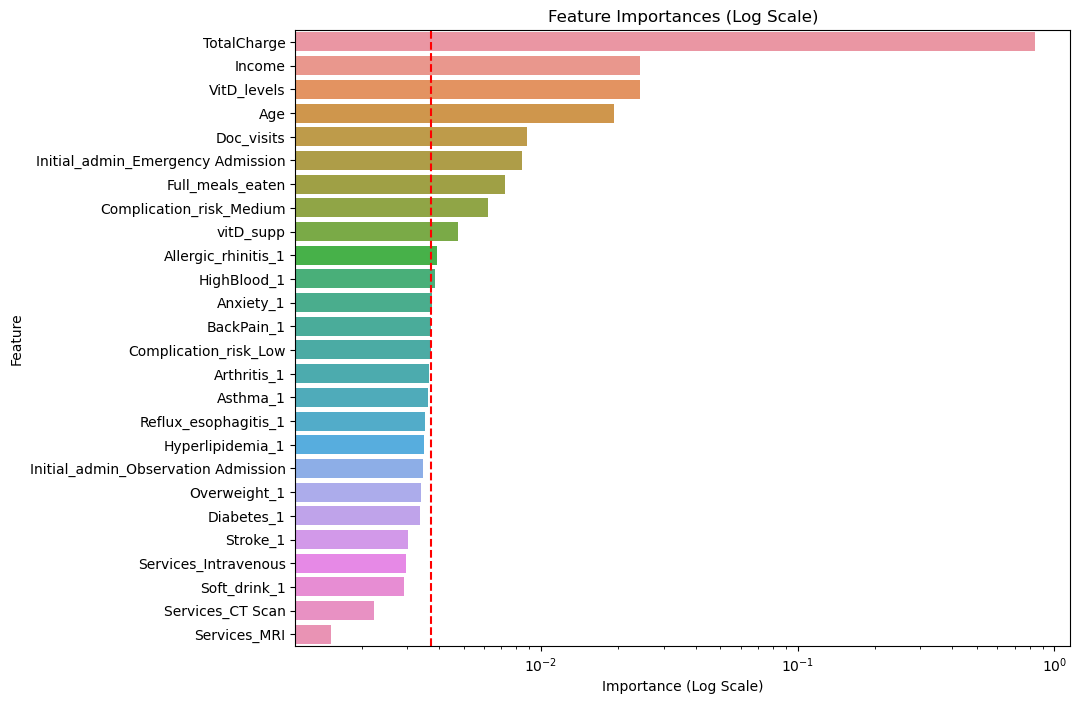

In [24]:
# Plot the feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.xscale('log')  # Apply logarithmic scale
plt.axvline(x=threshold, color='red', linestyle='--')
plt.title('Feature Importances (Log Scale)')
plt.xlabel('Importance (Log Scale)')
plt.ylabel('Feature')
plt.show()

In [25]:
# Select features above the threshold
features_to_keep = X.columns[importances > threshold]
print(f"Features kept: {features_to_keep.tolist()}")
X_reduced = X[features_to_keep]

Features kept: ['Age', 'Income', 'VitD_levels', 'Doc_visits', 'Full_meals_eaten', 'vitD_supp', 'TotalCharge', 'Initial_admin_Emergency Admission', 'HighBlood_1', 'Complication_risk_Medium', 'BackPain_1', 'Anxiety_1', 'Allergic_rhinitis_1']


# Conclusion and Next Steps

Finally, we compare the model's performance before and after feature reduction. This comparison is crucial in determining whether our feature reduction strategy has improved or maintained the model's effectiveness while simplifying it.

In [26]:
# Perform cross-validation with reduced features
cv_scores_reduced = cross_val_score(random_forest_model, X_reduced, y, cv=kfold, scoring='accuracy')

# Calculate mean and standard deviation of scores
mean_cv_scores_reduced = np.mean(cv_scores_reduced)
std_cv_scores_reduced = np.std(cv_scores_reduced)

print(f"Mean CV Accuracy with reduced features: {mean_cv_scores_reduced:.4f}")
print(f"Standard Deviation in CV Scores: {std_cv_scores_reduced:.4f}")

Mean CV Accuracy with reduced features: 0.9691
Standard Deviation in CV Scores: 0.0026
